# Edge Detection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from skimage.transform import resize
import imutils
from fastai.vision import *
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from scipy import ndimage
import sys
from fastai.vision import Image
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import cv2
from matplotlib import pyplot as plt
import numpy as np
import PIL
from skimage.transform import resize
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from IPython.display import clear_output
import time
import bisect as bi

from helper_functions import *

In [3]:
path = Path('/storage')
path_lbl = path/'vocal_cords_and_rings_data/data/labels'
path_img = path/'vocal_cords_and_rings_data/data/images'
path_trained_model = path/'vocal_cords_and_rings_data/data/models'
path_lbl = path_lbl.resolve()
path_img = path_img.resolve()

num_classes = 4 #everything_else, vocal_cords, tracheal_rings, bifurcation

DEBUG_MODE = False

## Set up learner

In [4]:
learn = load_learner(path_trained_model, 'stage-2-big-0614-rn101.pkl')

In [5]:
def inference(frame):
    '''
    All the steps, one by one:
    
    frame_rgb = frame[...,::-1] #convert bgr to rgb

    t = Image(pil2tensor(PIL.Image.fromarray(frame_rgb).convert("RGB"), np.float32).div_(255))
    prediction = learn.predict(t)
    p = prediction[1].squeeze() #prediction data

    mask = np.array(p).astype(np.uint8)
    '''
    return np.array(
        learn.predict(Image(pil2tensor(PIL.Image.fromarray(frame[...,::-1]).convert("RGB"), np.float32).div_(255)))[1].squeeze()
        ).astype(np.uint8)

def unwrap_image(mask):
    
    ####### Find centroid of bifurcation#####
    mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
    labels = get_blobs(mask,imshow=False)
    thresh = labels[3]
    thresh = img_as_uint(thresh*100)

    if len(np.where( thresh > 0 )[0]):
        # calculate moments of binary image
        M = cv2.moments(thresh)
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX = 125
        cY = 150
        
    ###### endof find centre ############
    
    value = np.sqrt(((mask.shape[0]/2.0)**2.0)+((mask.shape[1]/2.0)**2.0))
    polar_image = cv2.linearPolar(mask.astype(np.float32),(cX,cY), value, cv2.WARP_FILL_OUTLIERS).astype(np.uint8)[:,:,0]
    
    return polar_image

def find_posterior_region(mask, prev_posterior_angles=None, posterior_region_ctr=0):
    if len(mask.shape)>2:
        raise Exception('Mask should be grayscale image.')
    
    posterior_region_ctr+=1
    
    # Find anterior and posterior parts of trachea
    histogram = np.sum((mask==1).astype(np.uint8), axis=1)#row-wise sums
    region, posterior_angle = longest_contiguous_region(histogram < 5, histogram)
    
    if prev_posterior_angles is not None:
        #Average previous angles
        prev_posterior_angles[posterior_region_ctr%len(prev_posterior_angles)]=posterior_angle
        posterior = int(np.average(prev_posterior_angles))
        
        return posterior_angle, prev_posterior_angles, posterior_region_ctr

    return posterior_angle, None, None

def get_posterior_corrected_frame(mask, posterior):
    temp = mask[0:posterior,0:]
    return np.concatenate((mask[posterior:,0:],temp))

In [6]:
class Tracker():
    
    def __init__(self, init_frame=None, _verbose=False):
#         import pdb; pdb.set_trace()
        self.mid_blob_tracks = []
        self.mid_prev=[]
        self.verbose=_verbose
        mask_continuous=init_frame

        blobs_prev = get_blobs_single_class(mask_continuous==1, label_value=255)
        
        self.mid_blob_tracks = []
        for m in blobs_prev:
            if blob_area(m[112:122:])>0:
                M = cv2.moments((m[112:122:]>0).astype(np.uint8))
                cX = int(M["m10"] / M["m00"])
                self.mid_blob_tracks.append([cX])
        self.mid_blob_tracks.sort(reverse=True)
        mid_temp = get_middle_section(blobs_prev, collapse_channels=False)
        
        self.mid_prev=[]
        for mid in mid_temp:
            if blob_area(mid)>0:
                self.mid_prev.append(mid)
    
    def iterate(self, new_frame, ring_value=1):
        img = new_frame==ring_value
        
        #Find all blobs in current frame
        blobs_current = get_blobs_single_class(img, label_value=255)
        mid_temp = get_middle_section(blobs_current, collapse_channels=False)
        mid_new = []
        for mid in mid_temp:
            if blob_area(mid)>0:
                mid_new.append(mid)
                
        #Correlate children to parent blobs
        # blobs_new has the joined blobs with indices corresponding to their parents
#         import pdb; pdb.set_trace()
        blobs_new, orphans = correlate_blobs(mid_new, self.mid_prev, orphan_min_area=50)
        if blobs_new is None:
            print("EMPTY!!")
        
        #Add orphans to blobs_prev, so they can become parents in the next iteration
        #Note: this happens AFTER children have already found their parents
        self.mid_prev = []
        for blob_ in blobs_new:
            if blob_area(blob_[0])>0:
                self.mid_prev.append(blob_[0])
        #debug check
        for en, bl in enumerate(self.mid_prev):
            if blob_area(bl)<1:
                print("Empty blob at mid_prev[{}]".format(en))

        orphan_imgs = [np.array(o[0]).astype(np.uint8) for o in orphans]
        for o in orphan_imgs:
            if blob_area(o)>0:
                 self.mid_prev.append(o)
        
        for ctr,m in enumerate(blobs_new):
            M_prev = cv2.moments((m[1]>0).astype(np.uint8))
            cX_prev = int(M_prev["m10"] / M_prev["m00"])
            last_values = [track[-1] for track in self.mid_blob_tracks]

            if blob_area(m[0])>0: #non-empty child
                M = cv2.moments((m[0]>0).astype(np.uint8))
                cX = int(M["m10"] / M["m00"])        

                if cX_prev not in last_values:
                    raise Exception('Bad correlation. Parent not in list')

                self.mid_blob_tracks[last_values.index(cX_prev)].append(cX)
            else:#child is empty
                print("{} NO CHILD!!!".format(ctr))
                self.mid_blob_tracks[last_values.index(cX_prev)].append(None)
                
        #Insert at beginning (right-most blobs)
#         import pdb; pdb.set_trace()
        last_values = [track[-1] for track in self.mid_blob_tracks]
        try:
            start_none, end_none = get_non_None_section(last_values)
        except Exception as e:
            if hasattr(e, 'message'):
                print(e.message)
            else:
                print(e)
            #Return out of iterate() indicating failed tracking
            return False
            
        right_orphans = sorted(get_centroid_x(o[0]) for o in orphans if get_centroid_x(o[0]) > last_values[start_none])

        for cX in right_orphans:
            last_values = [track[-1] for track in self.mid_blob_tracks]
            print("right_orphan: {}".format(cX))
            for j, val in enumerate(last_values):
                if val is not None:
                    if j==0 and cX > self.mid_blob_tracks[j][-1]:
                        self.mid_blob_tracks = [[cX]] + self.mid_blob_tracks
                        break
                    elif j!=0 and self.mid_blob_tracks[j-1][-1] is None and cX > self.mid_blob_tracks[j][-1]:
                        self.mid_blob_tracks[j-1].append(cX)
                    #break is intentionally outside of elif
                    break
        #Insert at end (left-most blobs)
        last_values = [track[-1] for track in self.mid_blob_tracks]
        start_none, end_none = get_non_None_section(last_values)
        left_orphans = sorted(get_centroid_x(o[0]) for o in orphans if get_centroid_x(o[0]) < last_values[end_none])
        left_orphans.reverse()

        for cX in left_orphans:
            print("left_orphan: {}".format(cX))
            last_values = [track[-1] for track in self.mid_blob_tracks]
            for j, val in enumerate(reversed(last_values)):
                ctr = len(last_values)-1-j
                print("before None check {}, j={}, val={}".format(cX,j,val))
                if val is not None:
                    print("after None check {}".format(cX))
                    if ctr==len(last_values)-1 and cX < self.mid_blob_tracks[ctr][-1]: #i.e. last element in un-reversed last_values)
                        self.mid_blob_tracks = self.mid_blob_tracks+[[cX]]
                        print("first if {}".format(cX))
                        break

                    elif ctr!=len(last_values)-1 and self.mid_blob_tracks[ctr+1][-1] is None and cX < self.mid_blob_tracks[ctr][-1]:
                        self.mid_blob_tracks[ctr+1].append(cX)
                        print("second if {}".format(cX))
                    #break is intentionally outside of elif
                    break
                    
        #Must remove None islands before inserting a centre blob into tracks
        last_values = [track[-1] for track in self.mid_blob_tracks] #THIS ONE IS NEW - CHECK THAT IT WORKS IF NOT REMOVE LINE
        start_none, end_none = get_non_None_section(last_values)
        temp_tracks=[]
        idx_is_none = [val is None for val in [track[-1] for track in self.mid_blob_tracks][start_none: end_none+1]]
        for j,val in enumerate(idx_is_none):
            if val is False:
                temp_tracks=temp_tracks+[self.mid_blob_tracks[j+start_none]]
        self.mid_blob_tracks = self.mid_blob_tracks[:start_none]+temp_tracks+self.mid_blob_tracks[end_none+1:]

        #Insert at centre (in between other blobs in frame)
        last_values = [track[-1] for track in self.mid_blob_tracks]
        start_none, end_none = get_non_None_section(last_values)
        centre_orphans = sorted(get_centroid_x(o[0]) for o in orphans if get_centroid_x(o[0]) < last_values[start_none] and get_centroid_x(o[0]) > last_values[end_none])
        
        for cX in centre_orphans:
            print("MIDDLE BLOB BEING INSERTED cX: {}".format(cX))
            last_values = [track[-1] for track in self.mid_blob_tracks][start_none: end_none+1]
            #must reverse list for insort to work properly (i.e. insort requires low to hi sorted)
            last_values.reverse()
            bi.insort(last_values, cX)
            last_values.reverse()
            idx = last_values.index(cX)+start_none
            self.mid_blob_tracks=self.mid_blob_tracks[:idx]+[[cX]]+self.mid_blob_tracks[idx:]
            
        
        last_values = [track[-1] for track in self.mid_blob_tracks]
        
#         import pdb; pdb.set_trace()
        cimg = plot_blobs_in_order([b[0] for b in blobs_new if blob_area(b[0])>0],blobs_current,last_values,plot=True)
        
        if self.verbose:
            fig=plt.figure(figsize=(24,24))
            columns = 3
            rows = 1
            
            imgs = [intersect,img, img-intersect]
            for i in range(1, columns*rows +1):
                fig.add_subplot(rows, columns, i)
                plt.imshow(imgs[i-1])
            plt.show()
            
        return True #successful tracking

In [7]:
def correlate_blobs(new_blobs, prev_blobs, percent_overlap_thresh=0.75, child_area_thresh=1.5, orphan_min_area=50):
    """
    Link parent blobs from prev_blobs to children blobs from new_blobs
    constraints:

    0) children can only have one parent. parents can have multiple children

    1) children must have a large enough intersection with their parent

    2) children must be smaller than their parents (they are allowed to be larger up to a certain threshold)
    if a potential child has a strong correlation to a given potential parent (large intersection), it is only
    considered a child if child_area < parent_area*thresh (where thresh is >= 1)
    else if a potential child has a strong correlation to a given potential parent, and it doesn't meet the area criteria,
    a new track is created for it and it is parentless (TODO: consider going "back" in the tree and grouping previous blobs
    and considering them as a single blob so that the area criteria is met. rn thinking not needed)

    Args:
        new_blobs: list in which each channel is a grayscale image
                   that contains a single blob present in current 
                   frame (see get_blobs_single_class() )
        prev_blobs: list in which each channel is a grayscale image
                   that contains a single blob present in previous
                   frame (see get_blobs_single_class() )
        percent_overlap_thresh (default: 0.75): minimum amount that
                   child must overlap with parent to be considered
                   a child
        child_area_thresh (default: 1.5): child can be up to
                   child_area_thresh times bigger than its parent
                   to be considered a child
        orphan_min_area (default: 50): minimum area for a parentless
                   blob to be added to orphan list. All orphans with
                   less than orphan_min_area will be disregarded
                   
    Returns:
        family, orphans
        
        family: list of tuples of (child_blob, parent_blob) i.e. the
                actual frames are tuple[0] and tuple[1]
                If a parent has no children, entry will be (zero_arr, parent_blob)
                len of family is num_parent_blob
                
        orphans: list of tuples of (orphan_blob, None) i.e. the actual
                frame is tuple[0], and tuple[1] is None
                len of orphans is the number of orphans in current frame
                   
    """
    parent_to_children = {} #key is the parent ID, value is the child ID
    orphans = [] # IDs of blobs without parents
    
    #Make all children empty lists
    for p in range(0, len(prev_blobs)):
        parent_to_children[p] = [] 
    
    #Populate parent_to_child dict (children pick their parents)
    for c in range(0, len(new_blobs)):
        nblob = new_blobs[c]
   
        max_intercept = 0
        max_intercept_p = -1
                        
        for p in range(0,len(prev_blobs)):
            pblob = prev_blobs[p]
            intersect = cv2.bitwise_and(nblob, pblob)
            
            if blob_area(intersect) > max_intercept:
                max_intercept = blob_area(intersect)
                max_intercept_p = p
          
        if max_intercept > 0 and blob_area(nblob) < blob_area(prev_blobs[max_intercept_p])*child_area_thresh and max_intercept > blob_area(nblob)*0.10:
            parent_to_children[max_intercept_p].append(c) #Huzzah! Child picked a parent
#             print("nparents {} -child {} picked {} ".format(len(prev_blobs), c, max_intercept_p))
        else: #Child has no parent
            orphans.append(c)
                    
    #Join children blobs (if they belong to the same parent) to deal with blob separation
    #and add (child,parent) tuple to a "family" list
#     joined_blobs = {} # len(new_blobs) == len(prev_blobs)+len(orphans)
    family = []
    
    for p in range (0, len(parent_to_children)):
#         joined_blobs[p] = []
        if len(parent_to_children[p])>1: #parent has more than one child
            joined_blob = np.zeros_like(prev_blobs[0])
            for child_blob_index in parent_to_children[p]:
                joined_blob = cv2.bitwise_or(new_blobs[child_blob_index], joined_blob)
#                 print("JOINED BLOB TYPE {}".format(joined_blob.dtype))
#                 print("joined_blobs shape: {}".format(joined_blob.shape))
#             joined_blobs[p].append(joined_blob)
            family.append((joined_blob,prev_blobs[p]))
            
        elif len(parent_to_children[p])==1:
            joined_blob = new_blobs[parent_to_children[p][0]]
#             joined_blobs[p].append(joined_blob)
            family.append((joined_blob,prev_blobs[p]))
        else: #do nothing -> i.e. a parent that didn't have a child will die
            family.append((np.zeros_like(prev_blobs[p]),prev_blobs[p]))
    
    #Add orphans to the future parents list, so they can have children
    orphan_imgs = []
    for o in orphans:
        if np.count_nonzero(new_blobs[o]) > orphan_min_area:
            orphan_imgs.append((new_blobs[o], None))
        
    
    return family, orphan_imgs #joined_blobs has prev_parents+orphans number of channels, each channel being an individual blob

In [8]:
def collapse_channels(blobs):
    """
    Collapses all image channels into a single frame

    Reverses get_blobs_single_class

    Args:
        blobs: multi-channel image
    Returns:
        all blobs in a single frame
    """
    blobs_new_frame = np.zeros_like(blobs[0])

    for b in blobs:
        blobs_new_frame = np.array(blobs_new_frame) | np.array(b)
    return blobs_new_frame

def get_centroid_x(o):
    if blob_area(o)>0:
        M = cv2.moments((o>0).astype(np.uint8))
        cX = int(M["m10"] / M["m00"])
        return cX
    
def get_non_None_section(last_values):
    # No blobs had children. Lost tracking
    if last_values.count(None) == len(last_values):
        raise Exception('Error tracking. Was not able to correlate any blobs. Must reset')
    
    start_none = 0
    end_none = len(last_values)-1
    for j, val in enumerate(last_values):
        if val is not None:
            start_none=j
            break
            
    for j, val in enumerate(reversed(last_values)):
        ctr=len(last_values)-1-j
        if val is not None and ctr >= start_none:
            end_none=ctr
            break
    return start_none, end_none

def plot_blobs_in_order(mid_blobs, blobs, last_values, plot=True):
    if len(mid_blobs)>len(blobs):
        print("Error: Mismatched midblobs len len ({}) and blobs ({}).".format(len(mid_blobs), len(blobs)))
        return
    
    output_frame = np.zeros_like(blobs[0])
    for mb in mid_blobs:
        ID = last_values.index(get_centroid_x(mb))
        for i, b in enumerate(blobs):
            output_frame = (output_frame) | (b/np.max(b)*20).astype(np.uint8)
            if blobs_intersect(mb,b[112:122:].astype(np.uint8)):
                output_frame = (output_frame) | (b/np.max(b)*(ID+1)*25).astype(np.uint8)
                del blobs[i]
                break
    numbers_frame = np.zeros((224,224), np.uint8)
    
    start_none, end_none = get_non_None_section(last_values)
    for cX in last_values[start_none: end_none+1]:
        cv2.putText(numbers_frame , "{}".format(last_values.index(cX)), (cX, 120), cv2.FONT_HERSHEY_SIMPLEX,0.3, 255, 1)
    output_frame = (output_frame) | (numbers_frame).astype(np.uint8)
    
    if plot: pltimg(output_frame)
    
    return output_frame

## Setup Video

In [9]:
cap = cv2.VideoCapture('/storage/vocal_cords_and_rings_data/nbs/20181010_12y_5031752 mild subglottic stenosis uneditted.mpg')
print ("Cap fps: {}".format(cap.get(cv2.CAP_PROP_FPS)))
ctr = 0

######PARAMS######
#fps of the input video
fps=30
#start time for annotation (in seconds)
start_time_s= 45
#end time for annotation (in seconds)
end_time_s = 54
mask_timeline = []
clean_timeline = []
clean_flattened_timeline = []
frame_timeline = []

# debug only
eroded_timeline = []
###ENDOF PARAMS###

#Advance to starting frame
for i in range(0,start_time_s*fps):
    ret, frame = cap.read()
    ctr+=1
for _ in range(0,72):
    ret, frame = cap.read()
ret, frame = cap.read() #frame is uint8

Cap fps: 29.97002997002997


In [11]:
clear_output()
print ("Starting!")

#For finding posterior region
posterior_region_ctr = 0
prev_posterior_angles = [int(224/4),int(224/4),int(224/4),int(224/4)]
#endof For finding posterior region


#For tracking
tracker=None
#endof For tracking
ctr=0
while(cap.isOpened() and ctr <end_time_s*fps):

    ctr+=1
    print("ctr {}".format(ctr))
    
    ret, frame = cap.read() #frame is uint8
    if np.shape(frame) == (): #i.e. empty frame
        break
    
    # Perform inference
    mask = inference(frame)

    # Convert from linear to polar
    polar_image = unwrap_image(mask)

    # Clean up linear image
    clean_img = cv2.erode(polar_image,np.ones((11,1)))
#     clean_flattened_timeline.append((clean_img,(cX,cY)))
    
    #Finding posterior region
    posterior, prev_posterior_angles, posterior_region_ctr = find_posterior_region(clean_img, prev_posterior_angles, posterior_region_ctr)
    mask_continuous = get_posterior_corrected_frame(clean_img, posterior)
    print((mask_continuous.dtype,isinstance(mask_continuous,(np.ndarray)),mask_continuous.shape))
#     import pdb; pdb.set_trace()
    
    #Tracking
#     clear_output(wait=True)
    print("Prev post ang: {}, ctr:{}".format(prev_posterior_angles, posterior_region_ctr))
    img = mask_continuous==1
    if tracker is None:
        tracker=Tracker(init_frame=img)
    else:
        success = tracker.iterate(img)
        #Restart tracker from next frame if tracker is not successful
        if not success: tracker = None
    print("DTYPE: {}".format(img.shape))

    if DEBUG_MODE:
        #Tests for optimal erosion level
        e_list = []
        for num in range(5,12):
            e = cv2.erode(polar_image,np.ones((num,1)))
            e_list.append(e)
        eroded_timeline.append(e_list)
        
        # Cleaned up linear image
        linear_image = cv2.linearPolar(e,(cX,cY), value, cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)
        clean_timeline.append(linear_image)
    
cap.release()
# out.release()
print ("End!")

Starting!
ctr 1
(dtype('uint8'), True, (224, 224))
Prev post ang: [56, 112, 56, 56], ctr:1
DTYPE: (224, 224)
ctr 2
(dtype('uint8'), True, (224, 224))
Prev post ang: [56, 112, 112, 56], ctr:2
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 3
(dtype('uint8'), True, (224, 224))
Prev post ang: [56, 112, 112, 112], ctr:3
DTYPE: (224, 224)
ctr 4
(dtype('uint8'), True, (224, 224))
Prev post ang: [112, 112, 112, 112], ctr:4
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 5
(dtype('uint8'), True, (224, 224))
Prev post ang: [112, 112, 112, 112], ctr:5
DTYPE: (224, 224)
ctr 6
(dtype('uint8'), True, (224, 224))
Prev post ang: [112, 112, 112, 112], ctr:6
Error tracking. Was not able to correlate any blobs. Must reset
DTYPE: (224, 224)
ctr 7
(dtype('uint8'), True, (224, 224))
Prev post ang: [112, 112, 112, 112], ctr:7
DTYPE: (224, 224)
ctr 8
(dtype('uint8'), True, (224, 224))
Prev post ang: [112, 112, 112, 112], ctr:8
Error 

KeyboardInterrupt: 

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

In [36]:
if isinstance(mask_continuous,(np.ndarray)):
        print("HI")

HI


## Finding the posterior region

In [26]:
mask_continuous_timeline = []

Posterior angle: 112 from 114
199


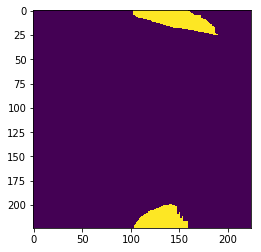

In [27]:
# posterior_region_ctr = 0
# prev_posterior_angles = [int(224/4),int(224/4),int(224/4),int(224/4)]

for mask, frame in zip(clean_flattened_timeline[71:], frame_timeline[71:]):
        
    frame_copy = frame.copy()
    frame_copy = cv2.linearPolar(img_as_float(frame_copy),(cX,cY), math.sqrt(value**2+value**2), cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)
    centreX, centreY = frame.shape[0]/2.0, frame.shape[1]/2.0

    L1 = 75
    L2 = 100
    
    p1 = np.round((centreX+L1*math.cos(posterior_angle),centreY+L1*math.sin(posterior_angle))).astype(np.int)
    p2 = np.round((centreX+L2*math.cos(posterior_angle),centreY+L2*math.sin(posterior_angle))).astype(np.int)
    cv2.arrowedLine(frame_copy, tuple(p1),tuple(p2), (255,0,0),3)
    
    
    mask_continuous_timeline.append(mask_continuous)

    
    print(ctr)
    
    if DEBUG_MODE:
        plt.imshow(mask_continuous)
        plt.show()
    time.sleep(1)
    clear_output(wait=True)
#####################

In [23]:
# while cap.isOpened():
#     r,f = capture.read()
#     pltimg(f)

## Tracking from scratch

TODO: Implement blob wise intersection. The corresponding blobs in frame t+1 will be the one that the current blob has the largest intersection with.

Should really work. Try!

In [71]:
hist = np.array([])
longest_contiguous_region(hist <5, hist)

IndexError: index 0 is out of bounds for axis 0 with size 0

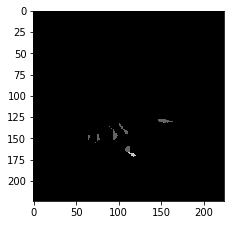

from find_posterior_region


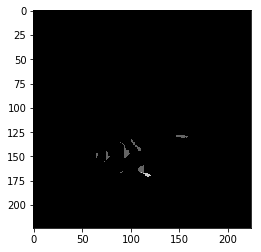

ValueError: too many values to unpack (expected 1)

In [63]:
## Tracking only the mid sections!
# capture = cv2.VideoCapture('/storage/vocal_cords_and_rings_data/nbs/20181010_12y_5031752 mild subglottic stenosis uneditted.mpg')
r, f = cap.read()
tracker = Tracker(init_frame=f)
###INIT FOR FIRST FRAME

for (i, img) in enumerate(mask_continuous_timeline[2:]):
    ret, frame = tracker.cap.read()
    pltimg(frame)
    tracker.iterate(frame)


In [201]:
%debug

> <ipython-input-200-ddb99f3852dd>(1)<module>()
----> 1 numbers_frame.shape

ipdb> numbers_frame.shape
*** NameError: name 'numbers_frame' is not defined
ipdb> numbers_frame
*** NameError: name 'numbers_frame' is not defined
ipdb> blobs[0].shape
*** NameError: name 'blobs' is not defined
ipdb> q


In [192]:
# cv2.cvtColor(cimg.ex, cv2.COLOR_BGR2HSV)
np.expand_dims(cimg,0).shape

(1, 224, 224)

In [146]:
last_values, get_non_None_section(last_values)

([], (0, -1))

In [147]:
# len(mid_blob_tracks)
mid_blob_tracks

[]

> <ipython-input-44-8725fc2fc189>(66)correlate_blobs()
     64         for p in range(0,len(prev_blobs)):
     65             pblob = prev_blobs[p]
---> 66             intersect = cv2.bitwise_and(nblob, pblob)
     67 
     68             if blob_area(intersect) > max_intercept:

ipdb> np.shape(mid_new)
(7, 10, 224)
ipdb> np.shape(mid_prev)
(3, 10, 224)
ipdb> pltimg(mid_new[0])


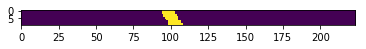

ipdb> pltimg(mid_new[1])


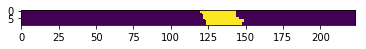

ipdb> pltimg(mid_new[2])


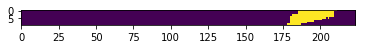

ipdb> pltimg(mid_new[3])


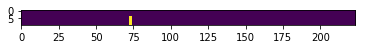

ipdb> pltimg(mid_new[4])


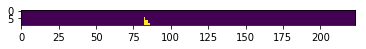

ipdb> pltimg(mid_new[5])


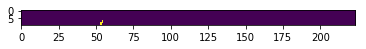

ipdb> pltimg(mid_new[6])


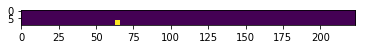

ipdb> pltimg(mid_new[7])
*** IndexError: list index out of range
ipdb> pltimg(mid_prev[0])


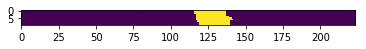

ipdb> pltimg(mid_prev[1])


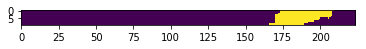

ipdb> pltimg(mid_prev[2])


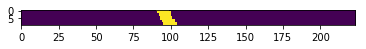

ipdb> pltimg(mid_prev[3])
*** IndexError: list index out of range
ipdb> pltimg(n_blob)
*** NameError: name 'n_blob' is not defined
ipdb> pltimg(nblob)


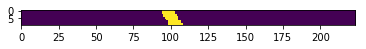

ipdb> pltimg(pblob)


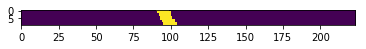

ipdb> nblob.dtype
dtype('uint8')
ipdb> pblob.dtype
dtype('int32')
ipdb> cv2.bitwise_and(nblob,pblob)
*** cv2.error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/core/src/arithm.cpp:223: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'
ipdb> cv2.bitwise_and(nblob,pblob.astype(np.uint8)
*** SyntaxError: unexpected EOF while parsing
ipdb> cv2.bitwise_and(nblob,pblob.astype(np.uint8))
array([[0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0],
       [0, 0, 0, 0, ..., 0, 0, 0, 0]], dtype=uint8)
ipdb> np.unique(cv2.bitwise_and(nblob,pblob.astype(np.uint8)))
array([  0, 255], dtype=uint8)
ipdb>

In [127]:
%debug

In [99]:
# contiguous_regions([False,False,True,True,False,True,False])
l = [False,2,3,False,5,False]
l3 = [1,None,None,4,None,6]
# regs = contiguous_regions(l);regs

l2=[]
for j,val in enumerate(l):
    if val is False:
        l2=l2+[l3[j]]
# for val in l:
#     l2+=[
print(l2)
# l2 = l[0:regs[0][0]]
# for section in regs:
#     l2 = l2+l[section[0]:section[1]]

[1, 4, 6]


In [100]:
[val is None for val in [track[-1] for track in mid_blob_tracks][start_none: end_none+1]]

[False, True, False]

In [103]:
%debug

> <ipython-input-102-1207723cfc30>(51)<listcomp>()
     49         M_prev = cv2.moments((m[1]>0).astype(np.uint8))
     50         cX_prev = int(M_prev["m10"] / M_prev["m00"])
---> 51         last_values = [track[-1] for track in mid_blob_tracks]
     52 
     53         if blob_area(m[0])>0: #non-empty child

ipdb> temp_tracks
[86, 90, 91, 94, 96, 98, 100, 101, 104, 105, 104, 105, 106, 107, 108, 108, 112, 114, 116, 117, 119, 118, 121, 123, 126, 130, 134, 139, 144, 152, 160, 164, 170, 182, 182, 184, 186, 186, 192, 206, 66, 70, 71, 73, 75, 76, 77, 78, 80, 81, 79, 80, 80, 81, 82, 82, 84, 86, 87, 87, 87, 88, 89, 90, 91, 92, 94, 97, 101, 103, 109, 108, 108, 111, 110, 113, 117, 127, 133, 134, 53, 55, 55, 57, 59, 59, 61, 62, 64, 64, 62, 62, 61, 61, 63, 61, 64, 65, 64, 64, 64, 63, 65, 64, 66, 67, 67, 69, 70, 73, 76, 74, 72, 74, 75, 82, 85, None, 96, 99, 95]
ipdb> q


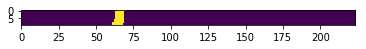

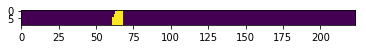

In [142]:
img = img==1
    
#Find all blobs in current frame
blobs_current = get_blobs_single_class(img, label_value=255)
mid_new = get_middle_section(blobs_current, collapse_channels=False)
pltimg(mid_new[5])
    
#Find all blobs in current frame
blobs_prev = get_blobs_single_class(prev_frame, label_value=255)
mid_prev = get_middle_section(blobs_prev, collapse_channels=False)
pltimg(mid_prev[4])

n, o = correlate_blobs([mid_new[5]], [mid_prev[4]], orphan_min_area=0)

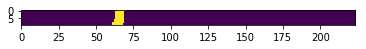

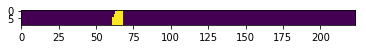

(1, 2, 10, 224)


In [143]:
pltimg(n[0][0])
pltimg(n[0][1])
print(np.shape(n))
# np.shape(mid_prev)

In [109]:
%debug

> <ipython-input-108-c37cb91e9cc4>(50)<listcomp>()
     48         M_prev = cv2.moments((m[1]>0).astype(np.uint8))
     49         cX_prev = int(M_prev["m10"] / M_prev["m00"])
---> 50         last_values = [track[-1] for track in mid_blob_tracks]
     51 
     52         if blob_area(m[0])>0: #non-empty child

ipdb> mid_blob_tracks
[[213, 212, 212, None], [176, 187, 191, 199, 206, 209, 212], [142, 149, 151, 155, 161, 164, 170], [110, 116, 117, 121, 125, 127, 130], [86, 90, 91, 94, 96, 98, 100], [66, 70, 71, 73, 75, 76, 77], [53, 55, 55, 57, 59, 59, 61], 53]
ipdb> q


TypeError: Invalid dimensions for image data

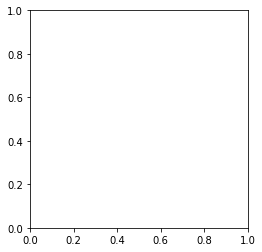

In [66]:
pltimg(mid_new)
pltimg(mid_prev)
# new_blobs, orphans=  correlate_blobs(blobs_prev[3],blobs_prev[3])

In [65]:
%debug

> /opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/image.py(646)set_data()
    644         if not (self._A.ndim == 2
    645                 or self._A.ndim == 3 and self._A.shape[-1] in [3, 4]):
--> 646             raise TypeError("Invalid dimensions for image data")
    647 
    648         if self._A.ndim == 3:

ipdb> mid_blob_tracks
*** NameError: name 'mid_blob_tracks' is not defined
ipdb> mid_blob_tracks
*** NameError: name 'mid_blob_tracks' is not defined
ipdb> q


In [147]:
colours = np.linspace(10,249,40).astype(np.uint8)

# index = random.randint(0,len(colours)-1)
np.random.shuffle(colours)
last = colours[-1]
last

242

/storage/vocal_cords_and_rings_data/nbs/helper_functions.py:386: RuntimeWarning: invalid value encountered in true_divide
  overlayed_children = (overlayed_children) | (b[0]/np.max(b[0])*colour).astype(np.uint8)


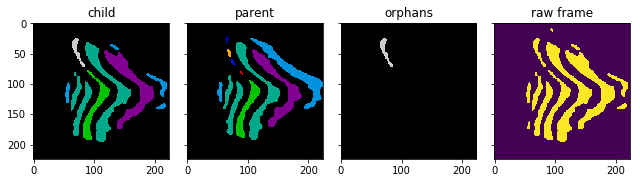

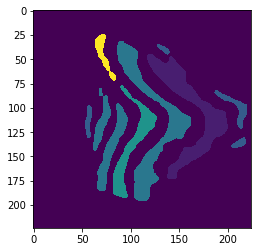

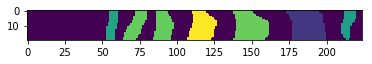

1


/storage/vocal_cords_and_rings_data/nbs/helper_functions.py:388: RuntimeWarning: invalid value encountered in true_divide
  overlayed_parents = (overlayed_parents) | (b[1]/np.max(b[1])*colour).astype(np.uint8)


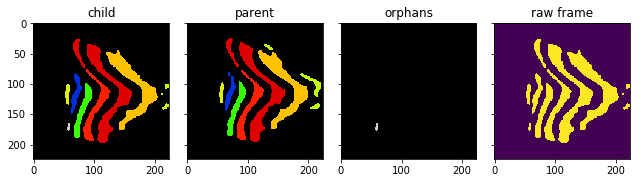

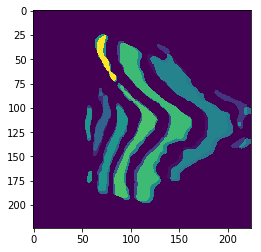

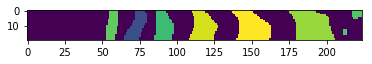

2


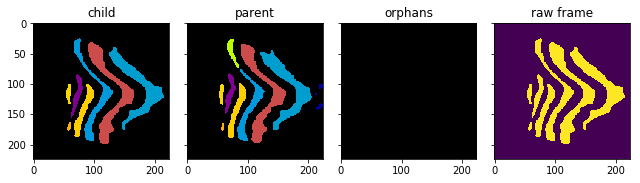

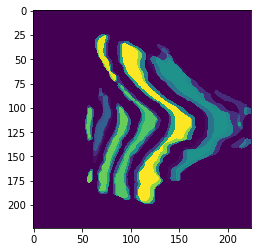

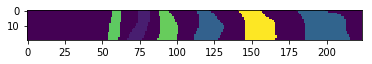

3


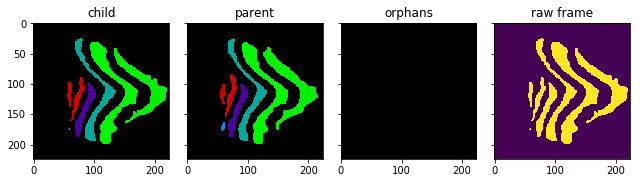

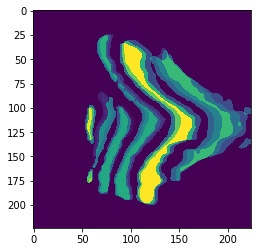

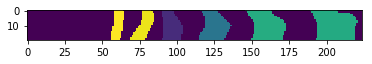

4


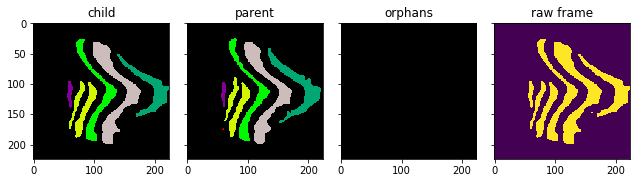

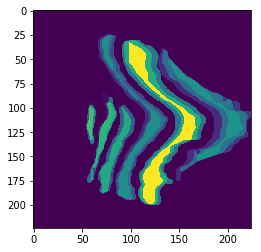

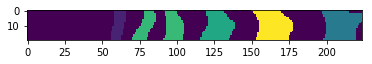

5


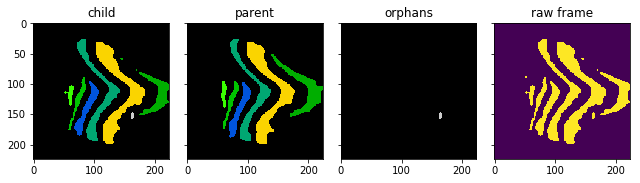

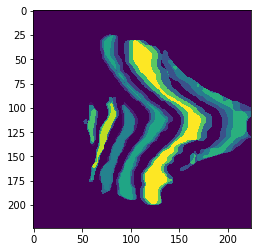

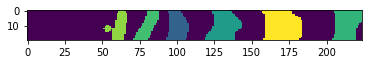

6


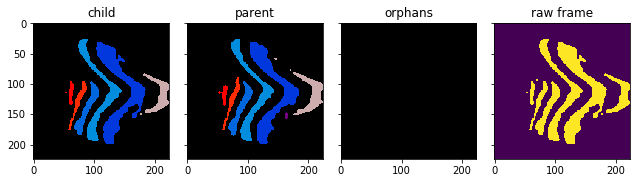

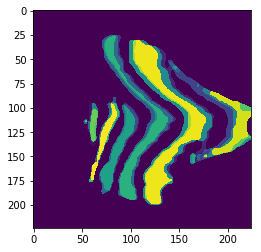

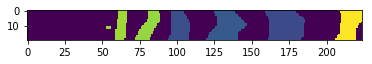

7


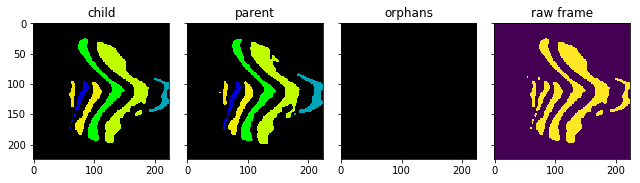

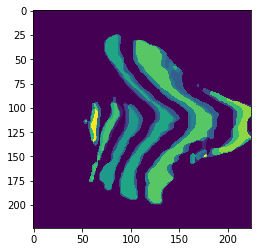

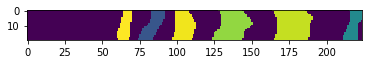

8


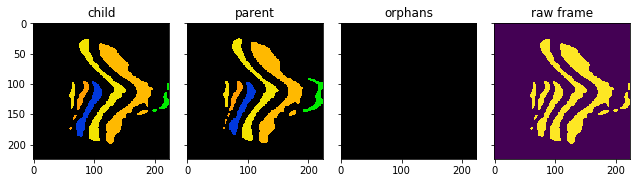

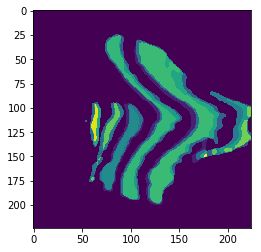

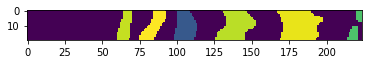

9


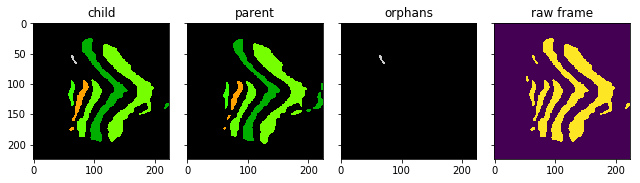

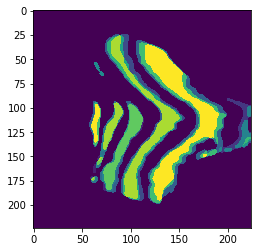

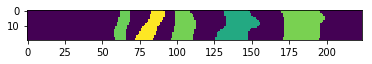

10


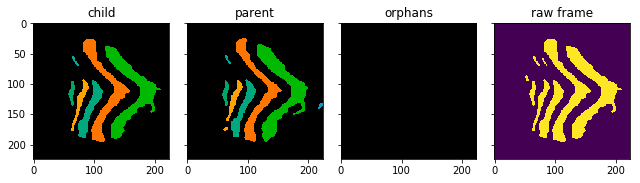

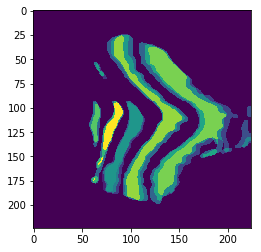

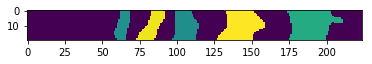

11


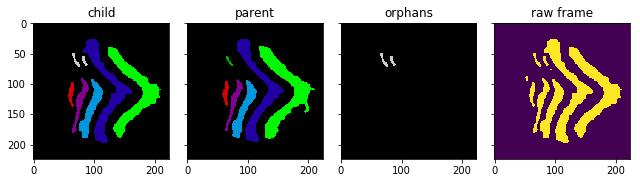

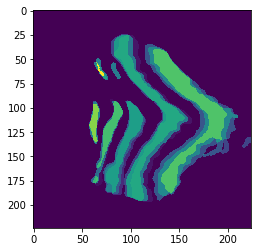

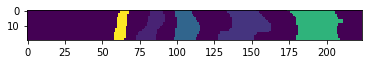

12


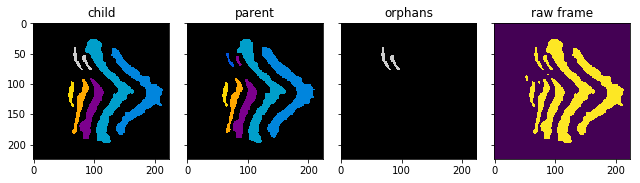

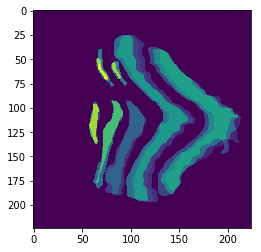

KeyboardInterrupt: 

In [65]:
## TEST ONE!!!

verbose = False
prev_frame = clean_blobs[0]
# prev_frame = avg_frames([mask_continuous_timeline[2],mask_continuous_timeline[1],mask_continuous_timeline[0]])
# prev_frame = clean_blobs[0]==255
# pltimg(prev_frame)
blobs_prev = get_blobs_single_class(prev_frame, label_value=255)
cnt = 0

# for img in clean_blobs:
prev_children = [np.zeros_like(clean_blobs[0]),np.zeros_like(clean_blobs[0]),np.zeros_like(clean_blobs[0])]
show_overlap = True
for (i, img) in enumerate(clean_blobs[2:]):
#     img = img==1

    #Attempt at averaging stuff
#     img = avg_frames([mask_continuous_timeline[i-2],mask_continuous_timeline[i-1],mask_continuous_timeline[i]])
#     pltimg(img)
#     pltimg(prev_frame)

#     clear_output(wait=True)
#     print("counter: {}".format(cnt))
    cnt +=1
    
    #Find blobs
    blobs_current = get_blobs_single_class(img, label_value=255)
#     blobs_prev = get_blobs_single_class(prev_frame, label_value=255)
    
    #Correlate children to parent blobs
    # blobs_new has the joined blobs with indices corresponding to their parents
    blobs_new, orphans = correlate_blobs(blobs_current, blobs_prev)
    
    if blobs_new is None:
        print("EMPTY!!")
#     print("blobs_new shape {}".format(np.shape(blobs_new)))
#     test_img = (blobs_new[0][0]/np.max(blobs_new[0][0])).astype(np.uint8) | (np.zeros_like(blobs_new[0][0]))
#     pltimg(blobs_new[cnt-1][0])
#     print("done test {}   {}".format(np.unique((blobs_new[0][0]/np.max(blobs_new[0][0])).astype(np.uint8)), np.unique(test_img)))
    
    #######WRONG! Cant just re-find blobs!!!! ...but it works.......
    #Collapse all new blobs into a single frame to make it "prev_frame" for the next iteration
#     blobs_new_frame = collapse_all_channels(blobs_new)   
#     blobs_prev = get_blobs_single_class(blobs_new_frame, label_value=255)
    
    #Add orphans to blobs_prev, so they can become parents in the next iteration
    #Note: this happens AFTER children have already found their parents
    blobs_prev = [blob_[0] for blob_ in blobs_new]
    orphan_imgs = [np.array(o[0]).astype(np.int32) for o in orphans]
    blobs_prev = blobs_prev+orphan_imgs
    
#     pltimg(img)
    children = plot_blob_generations(blobs_new, orphans, include_orphans=True, frame=img)
    
    if show_overlap: #Shows overlap of the past 3 frames. Good way of judging how difficult tracking will be
        prev_children[cnt%3] = children
        pltimg(prev_children[0]+prev_children[1]+prev_children[2])#   ---   (prev_children[cnt%3]+children)/np.max(prev_children[cnt%3]+children)
        pltimg(children[102:122,:])
#     if cnt ==5:
#         break
    
    prev_frame = img
    
    if verbose:
#         plt.imshow(intersect)
#         plt.show()

        fig=plt.figure(figsize=(24,24))
        columns = 3
        rows = 1

        # for c in range (71,100):
        imgs = [intersect,img, img-intersect]
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            plt.imshow(imgs[i-1])
        #     clear_output()
        plt.show()
    print(cnt)
#     time.sleep(0.5)
    
    